In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc

/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [3]:
import sys, os
sys.path.append('../src')

from interaction import Interaction
from util import compute_auc

In [136]:
# JING CLONAL EXPANSION
x_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_rna_filtered85.csv'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
y = pd.read_csv(y_path)['Y'].values

# # JING TUMOR TIL VS TEMRA
# x_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_x2.csv'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_y2.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/0.05_0.5_out'
# y = pd.read_csv(y_path)['y'].values

# # ALOK ANTIGEN SPECIFICITY 
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# y = pd.read_csv(y_path)['Antigen'].values - 1


In [137]:
from util import get_genes_from_slide_outs

lf_dict = get_genes_from_slide_outs(slide_outs)
lf_dict.keys()

dict_keys(['Z17', 'Z5', 'Z18', 'Z20', 'Z30'])

In [138]:
all_genes = np.unique(np.concatenate([lf_dict[lf] for lf in lf_dict]))
len(all_genes)

55

In [139]:
gene_embeddings = pd.read_csv('../data/ppi/human_embeddings.csv', index_col=0)
null_genes = [g for g in all_genes if g not in gene_embeddings.index]
print(f'Found {len(all_genes)-len(null_genes)}/{len(all_genes)} gene embeddings')

Found 51/55 gene embeddings


In [140]:
gene_embeddings = pd.concat([
    gene_embeddings, 
    pd.DataFrame(
        index=null_genes, 
        columns=gene_embeddings.columns).fillna(1)
    ], axis=0)

gene_embeddings = gene_embeddings.loc[all_genes]
gene_embeddings.shape

/tmp/ipykernel_28351/809699600.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=gene_embeddings.columns).fillna(1)


(55, 64)

In [141]:
# Create 0, 1 presence/absence matrix

gex_df = pd.read_csv(x_path, usecols=list(all_genes))
gex_threshes = gex_df.mean(axis=0)

mask_df = pd.DataFrame(
    np.where(gex_df > gex_threshes, 1, 0), 
    index=gex_df.index, 
    columns=gex_df.columns
)

mask_df.shape

(10191, 55)

In [142]:
gene_embeddings.shape, mask_df.shape

((55, 64), (10191, 55))

In [143]:
genept_df = np.einsum('ij,jk->ijk', mask_df.values, gene_embeddings)

genept_df = genept_df.reshape(gex_df.shape[0], -1)
genept_df.shape

(10191, 3520)

In [144]:
wgenept_df = gex_df @ gene_embeddings
wgenept_df.shape

(10191, 64)

In [145]:
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[list(lf_dict.keys())].values
z_matrix.shape

(10191, 5)

In [151]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neural_network import MLPClassifier

a=0.1
model = Lasso(alpha=a, max_iter=10000)

# model = LinearRegression() 

# model = MLPClassifier(max_iter=1000)

In [160]:
# SLIDE z-matrix performance
lasso0 = Estimator(model=model)

auc0 = lasso0.evaluate(z_matrix, y)

In [161]:
# Lasso regression on LF gene expression matrix
lasso1 = Estimator(model=model)

auc1 = lasso0.evaluate(gex_df.values, y)

In [162]:
# Lasso regression on mean-thresholded gene expression

lasso2 = Estimator(model=model)

auc2 = lasso2.evaluate(mask_df.values, y)

In [163]:
# Lasso regression on semantic embeddings

lasso3 = Estimator(model=model)

auc3 = lasso3.evaluate(genept_df, y)

In [164]:
# Lasso regression on semantic embeddings

lasso4 = Estimator(model=model)

auc4 = lasso3.evaluate(wgenept_df.values, y)

In [165]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3, auc4]),
    index=['z-matrix', 'gex', 'mask_gex', 'mask_ppi', 'w_ppi']
)
df.reset_index(inplace=True)
df = df.melt(id_vars='index', var_name='iter', value_name='auc')

In [166]:
def filter_pairs(pairs, df):
    filtered = []
    for i, j in pairs:
        if not np.all(df[df['index'] == i]['auc'].values == df[df['index'] == j]['auc'].values):
            filtered.append((i, j))
    return filtered

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mask_gex vs. mask_ppi: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.261e-02 Stat=6.223e+00
mask_ppi vs. w_ppi: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.197e-03 Stat=8.691e+00
gex vs. mask_ppi: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.152e-03 Stat=1.057e+01
mask_ppi vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.940e-03 Stat=9.606e+00


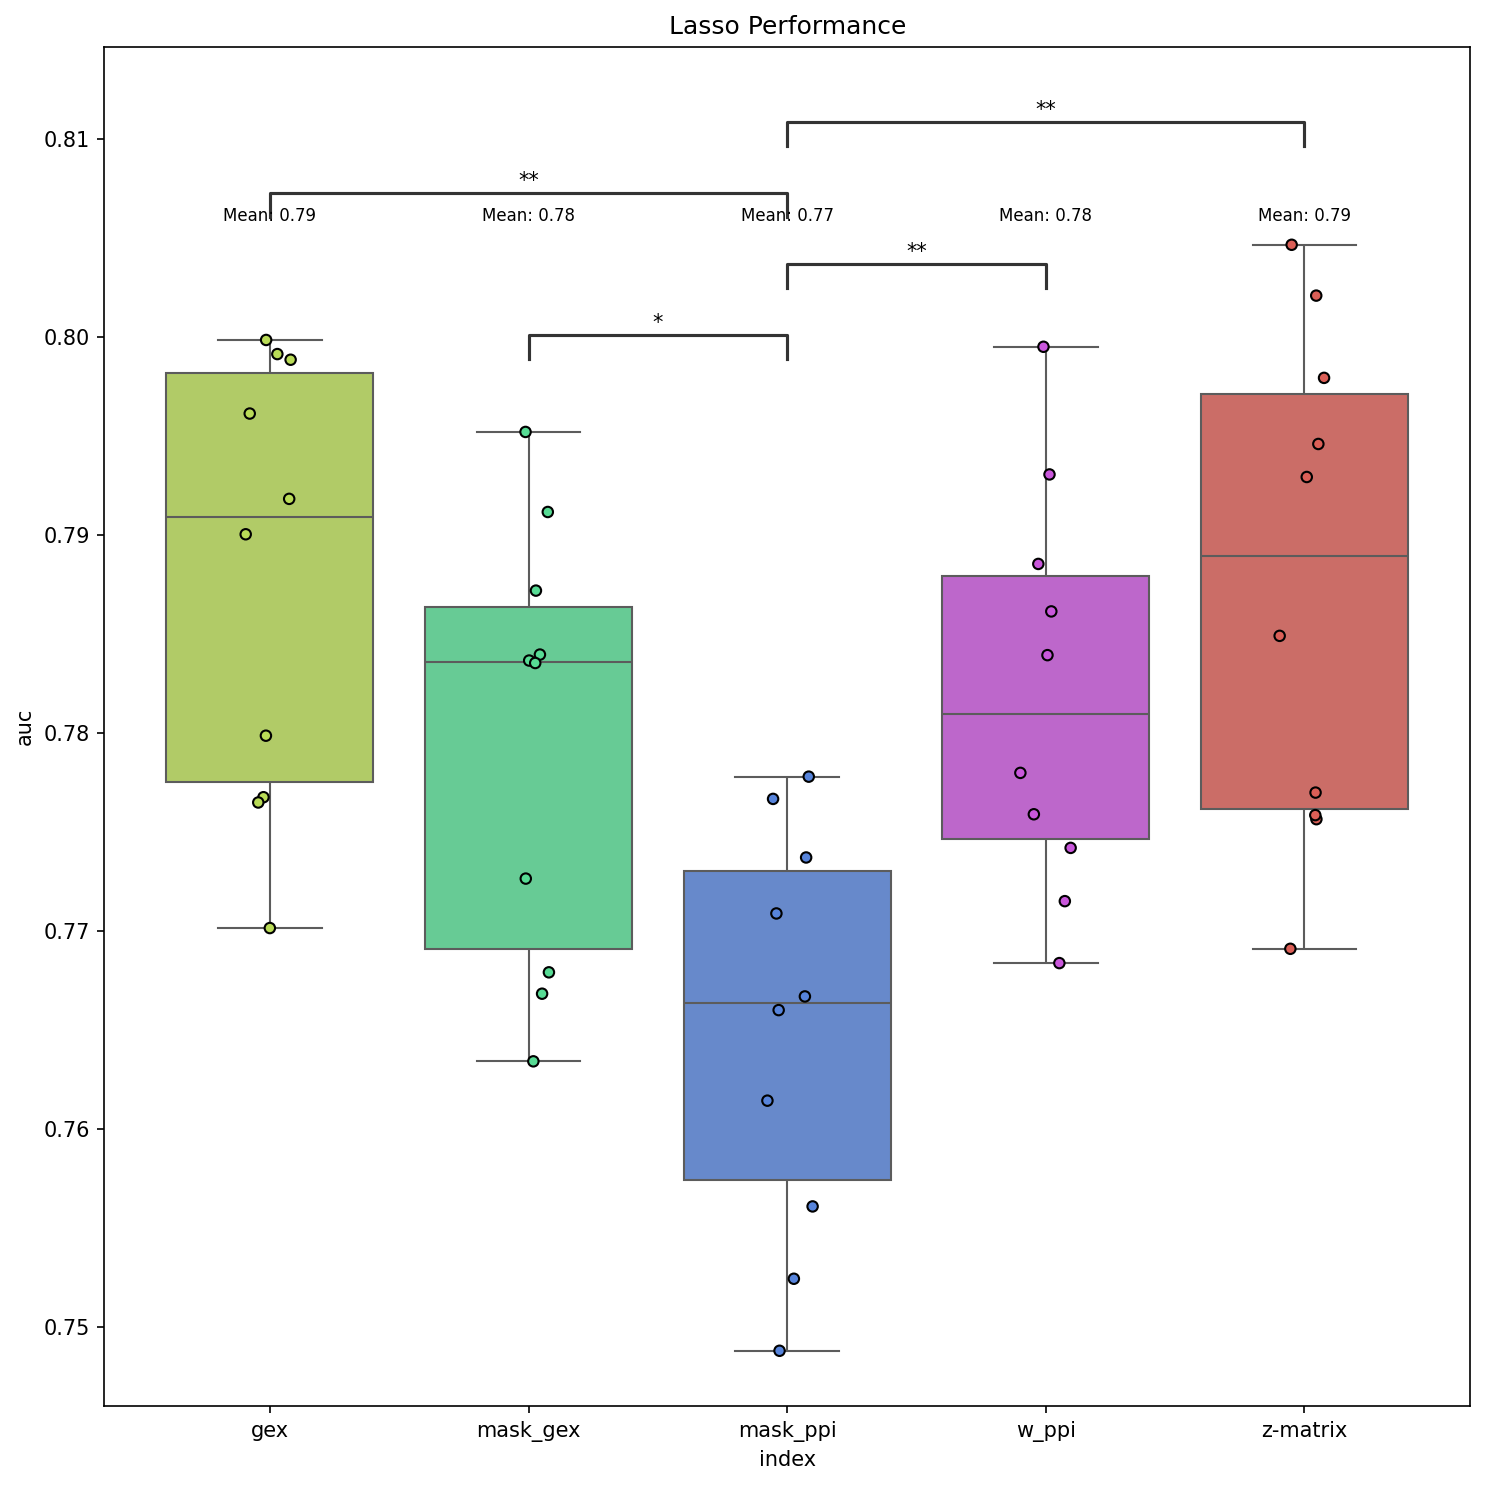

In [167]:
import seaborn as sns 
import matplotlib.pyplot as plt 
from statannotations.Annotator import Annotator
import itertools 

fig, ax = plt.subplots(figsize=(10,10), dpi=150)

sns.boxplot(data=df, x='index', y='auc', hue='index', palette='hls', ax=ax, showfliers=False, order=np.unique(df['index']))
sns.stripplot(data=df, x='index', y='auc', hue='index', ax=ax, palette='hls', legend=False, linewidth=1, edgecolor='black', jitter=True)

pairs=list(itertools.combinations(np.unique(df['index']), 2))
pairs = filter_pairs(pairs, df)

annotator = Annotator(ax, pairs, data=df, x='index', y='auc', order=np.unique(df['index']))
annotator.configure(test='Kruskal', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

means = df.groupby('index')['auc'].mean()
for i, mean in zip(means.index, means):
    plt.text(i, df['auc'].max()+0.001 , f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=8, color='black')

plt.title(f'{model.__class__.__name__} Performance')
plt.tight_layout()

In [ ]:
# with open(os.path.join(slide_outs, 'standard_out.txt'), 'r') as f:
#     standard_out = f.readlines()
# slide_auc = standard_out[-1].split(' ')[-2]

# slide_auc = '0.951218206396577'
# slide_auc = '0.747932' 

In [ ]:
# pd.DataFrame({
#     'slide': slide_auc[:8],
#     'z_matrix': auc0,
#     'gex': auc1,
#     'mask_gex': auc2,
#     'wgenept': auc3
# }, index=['auc']).T


### Make PPI embeddings

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# ppi_binary = pd.read_csv('/ix/djishnu/alw399/integration/data/HomoSapiens_binary_hq.txt', sep='\t')
# ppi_cocomp = pd.read_csv('/ix/djishnu/alw399/integration/data/HomoSapiens_cocomp_hq.txt', sep='\t')

ppi_binary = pd.read_csv('/ix/djishnu/alw399/integration/data/MusMusculus_binary_hq.txt', sep='\t')
ppi_cocomp = pd.read_csv('/ix/djishnu/alw399/integration/data/MusMusculus_cocomp_hq.txt', sep='\t')

ppi = pd.concat([ppi_binary, ppi_cocomp])

edges = ppi[['Gene_A', 'Gene_B']].values
edges.shape

In [ ]:
import networkx as nx 

G = nx.Graph()
G.add_edges_from(edges)

# nx.write_edgelist(G, '../data/ppi/HomoSapien_joint_hq.edgelist')
nx.write_edgelist(G, '../data/ppi/MusMusculus_joint_hq.edgelist')

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(
    graph=G, 
    dimensions=64, 
    walk_length=30, 
    num_walks=200, 
    workers=1,
    temp_folder='../data/ppi/tmp')  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
# model.wv.most_similar('2')  # Output node names are always strings


In [ ]:
# # Save embeddings for later use
# model.wv.save_word2vec_format('../data/ppi/HomoSapien_joint_hq.emd')

# # Save model for later use
# model.save('../data/ppi/HomoSapien_joint_hq.model')

In [ ]:
word_vectors = model.wv
word_vectors

In [ ]:
# Create a list of words and their corresponding vectors
words = list(word_vectors.key_to_index.keys())
vectors = [word_vectors[word] for word in words]

# Create a DataFrame
df = pd.DataFrame(vectors, index=words)

# Save the DataFrame to a CSV file
df.to_csv('../data/ppi/mouse_embeddings.csv')

### Gene sets

In [ ]:
path = '/ix/djishnu/Hanxi/Multiomics_Integration/raw_pathways/m2.cp.v2023.2.Mm.symbols.gmt'
pathways = pd.read_csv(path, sep='\t', header=None)
pathways